In [ ]:
from langchain import OpenAI, PromptTemplate
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import pandas as pd
import dspy
import numpy as np

#### Hypothesis Testing using Dspy

In [ ]:
turbo = dspy.OpenAI(model='gpt-3.5-turbo', api_key=OPENAI_API_KEY)
colbertv2_wiki17_abstracts = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')
dspy.settings.configure(lm=turbo, rm=colbertv2_wiki17_abstracts)

In [ ]:
class BasicQA(dspy.Signature):
    """
    You are an individual living in New York City (NYC) during the COVID-19 pandemic. You have a monthly income and current savings. You need to decide how much to spend each month based on the current situation of the number of COVID cases in NYC and your remaining savings.

    When the number of COVID cases is low and your savings are high, you feel more comfortable spending a larger portion of your income on non-essential expenses like dining out, entertainment, and travel. However, as the number of cases increases and your savings decrease, you become more cautious and prioritize essential expenses like rent, groceries, and utilities, reducing your spending on non-essential items.

    To help you understand the context better:
    - During a severe outbreak with a high number of COVID cases, people tend to stay at home more, avoid non-essential activities, and prioritize essential expenses like food and utilities. This reduces their overall spending, especially on non-essential items.
    - When the number of cases is low, and people feel safer, they are more likely to resume normal activities like dining out, entertainment, and travel, leading to higher spending on non-essential items.
    - Similarly, when individuals have higher savings, they feel more financially secure and are more willing to spend a larger portion of their income on non-essential expenses.
    - As savings decrease, individuals become more cautious and try to preserve their savings by cutting back on non-essential spending and prioritizing essential expenses.

    """
    context = dspy.InputField(desc="may contain relevant facts")
    question = dspy.InputField(desc="will contain the number of COVID cases in NYC, your monthly income, current savings, money spent in the same month of last year and the time of year (e.g., month and year) to help you decide how much to spend this month")
    # answer = dspy.OutputField(desc="often between 1 and 5 words representing realistic probability between 0 and 1 representing the fraction of your monthly income you would want to spend this month")
    answer = dspy.OutputField(desc="often between 1 and 5 words representing realistic probability between 0 and 1 representing the change in your spending behavior this month compared to this same month last year")


class RAG(dspy.Module):
    def __init__(self, num_passages=3):
        super().__init__()

        self.retrieve = dspy.Retrieve(k=num_passages)
        self.generate_answer = dspy.ChainOfThought(BasicQA)
    
    def forward(self, question):
        context = self.retrieve(question).passages
        prediction = self.generate_answer(context=context, question=question)
        return dspy.Prediction(context=context, answer=prediction.answer)

In [ ]:
from dspy.teleprompt import BootstrapFewShot

# Validation logic: check that the predicted answer is correct.
# Also check that the retrieved context does actually contain that answer.
def validate_context_and_answer(example, pred, trace=None):
    answer_EM = dspy.evaluate.answer_exact_match(example, pred)
    answer_PM = dspy.evaluate.answer_passage_match(example, pred)
    return answer_EM and answer_PM

# Set up a basic teleprompter, which will compile our RAG program.
teleprompter = BootstrapFewShot(metric=validate_context_and_answer)

# Compile!
compiled_rag = teleprompter.compile(RAG(), trainset=trainset)

In [78]:
from dspy.evaluate.evaluate import Evaluate

# Set up the `evaluate_on_hotpotqa` function. We'll use this many times below.
evaluate_on_hotpotqa = Evaluate(devset=valset, num_threads=1, display_progress=True, display_table=5)

# Evaluate the `compiled_rag` program with the `answer_exact_match` metric.
metric = dspy.evaluate.answer_exact_match
evaluate_on_hotpotqa(compiled_rag, metric=metric)

Average Metric: 1 / 6  (16.7): 100%|██████████| 6/6 [00:00<00:00, 873.97it/s]

Average Metric: 1 / 6  (16.7%)


,question,example_answer,context,pred_answer,answer_exact_match
0,Current number of COVID cases in NYC: 98254 Current savings: $13800.0 and Current date: 2022-08-18 00:00:00,2.2,"['Leonard v. Pepsico, Inc. | Leonard v. Pepsico, Inc., 88 F. Supp. 2d 116, (S.D.N.Y. 1999), aff\'d 210 F.3d 88 (2d Cir. 2000), more widely...",2.2,✔️ [True]
1,Current number of COVID cases in NYC: 177077 Current savings: $15200.0 and Current date: 2022-11-16 00:00:00,2.3,"['New York v. Onofre | The People v. Ronald Onofre, ""51 N.Y.2d 476, 415 N.E.2d 936, 434 N.Y.S.2d 947 (1980)"", was an appeal against New...",1.9,False
2,Current number of COVID cases in NYC: 127068 Current savings: $16400.0 and Current date: 2023-02-14 00:00:00,2.3,"['New York v. Onofre | The People v. Ronald Onofre, ""51 N.Y.2d 476, 415 N.E.2d 936, 434 N.Y.S.2d 947 (1980)"", was an appeal against New...",2.2,False
3,Current number of COVID cases in NYC: 12637 Current savings: $17800.0 and Current date: 2023-05-15 00:00:00,2.3,"['New York v. Onofre | The People v. Ronald Onofre, ""51 N.Y.2d 476, 415 N.E.2d 936, 434 N.Y.S.2d 947 (1980)"", was an appeal against New...",0.8,False
4,Current number of COVID cases in NYC: 189376 Current savings: $18600.0 and Current date: 2023-08-13 00:00:00,2.3,"['New York ex rel. Cutler v. Dibble | New York ex rel. Cutler v. Dibble, 62 U.S. (21 How.) 366 (1858), was a companion case...",0.8,False


16.67

In [76]:
# Ask any question you like to this simple RAG program.
my_question = "Current number of COVID-19 virus (or SARS-CoV-2 virus) cases in NYC: 100000 Current savings: $500 and Current date: 2024-04-11"

# Get the prediction. This contains `pred.context` and `pred.answer`.
pred = compiled_rag(my_question)

# Print the contexts and the answer.
print(f"Question: {my_question}")
print(f"Predicted Answer: {pred.answer}")
print(f"Retrieved Contexts (truncated): {[c[:200] + '...' for c in pred.context]}")

Question: Current number of COVID-19 virus (or SARS-CoV-2 virus) cases in NYC: 100000 Current savings: $500 and Current date: 2024-04-11
Predicted Answer: 0.3
Retrieved Contexts (truncated): ['Severe acute respiratory syndrome | Severe acute respiratory syndrome (SARS) is a viral respiratory disease of zoonotic origin caused by the SARS coronavirus (SARS-CoV). Between November 2002 and July...', 'SARS coronavirus | The SARS coronavirus, sometimes shortened to SARS-CoV, is the virus that causes severe acute respiratory syndrome (SARS). On April 16, 2003, following the outbreak of SARS in Asia a...', 'Pipistrellus bat coronavirus HKU5 | Pipistrellus bat coronavirus HKU5 (Bat-CoV HKU5) is an enveloped, positive sense, single-stranded RNA mammalian Group 2 betacoronavirus discovered in Japanese Pipis...']


In [77]:
turbo.inspect_history(n=1)





You are an individual living in New York City (NYC) during the COVID-19 pandemic. You have a monthly income and current savings. You need to decide how much to spend each month based on the current situation of the number of COVID cases in NYC and your remaining savings. Initially you were optimistic about the situation and were spending a larger portion of your income on non-essential expenses. However, as the number of COVID cases increased and your savings decreased, you became more cautious and started prioritizing essential expenses.

    When the number of COVID cases is low and your savings are high, you feel more comfortable spending a larger portion of your income on non-essential expenses like dining out, entertainment, and travel. However, as the number of cases increases and your savings decrease, you become more cautious and prioritize essential expenses like rent, groceries, and utilities, reducing your spending on non-essential items.

    To help you understand the 

In [ ]:
def dspy_predict(num_cases, current_savings,current_date):
    # Define the predictor.
    generate_answer = dspy.Predict(BasicQA)
    query = f"Current number of COVID cases in NYC: {num_cases} Current savings: ${current_savings} and Current date: {current_date}"
# Call the predictor on a particular input.
    pred = generate_answer(question=query)
# Print the input and the prediction.
    print(f"Question: {query}")
    print(f"Predicted Answer: {pred.answer}")
    return pred.answer
dspy_predict(1000, 500,datetime.now().strftime("%Y-%m-%d"))

In [ ]:
retrieve = dspy.Retrieve(k=3)
topK_passages = retrieve("Current number of COVID-19 virus (or SARS-CoV-2 virus) cases in NYC: 1000 Current savings: $500 and Current date: 2024-04-11").passages
for idx, passage in enumerate(topK_passages):
    print(f'{idx+1}]', passage, '\n')

Setup Testing and Training Data

In [ ]:
def simulate_spending(start_date, end_date, initial_savings):
    savings = initial_savings
    earnings = 2000  # Assume a monthly income of $5,000
    spending_history = []
    dates = []
    case_numbers = []
    savings_history = [initial_savings]
    spending_percent_change_history = []
    spending_percent_change_from_year_ago_history = []
    query_list = []
    consumption_rate_change = [3.1, 2.7, 2.4, 2.4, 2.1, 2.3, 2.2, 2.2, 2.1, 2.3, 2.2, 2.3, 2.3, 2.3, 2.3, 2.5, 1.0, 1.9, 1.6, 3.2, 4.7, 5.1, 7.8, 9.0, 7.1, 5.4, 5.5, 5.0]
    current_date = start_date
    previous_spending = 1200 
    spending_year_ago = 1200  # Initialize spending from a year ago
    month_counter = 0
    while current_date <= end_date:
        # Simulate the number of COVID cases in NYC
        num_cases = random.randint(1000, 200000)
        case_numbers.append(num_cases)
        query = f"Current number of COVID cases in NYC: {num_cases} Current savings: ${savings} and Current date: {current_date}"
        query_list.append((query,consumption_rate_change[month_counter]))
        # Get the spending probability from the language model
        spending_probability_str = dspy_predict(num_cases=num_cases, current_savings=savings,current_date=current_date)

        # Extract the probability value from the output string
        spending_probability = float(spending_probability_str.split(": ")[1])

        # Calculate the spending amount based on the probability and earnings
        spending_amount = earnings * spending_probability
        spending_change = spending_amount - previous_spending
        
        if previous_spending != 0:  # Avoid division by zero
            spending_percent_change = (spending_amount - previous_spending) / previous_spending * 100
        else:
            spending_percent_change = 0
            
        spending_percent_change_history.append(spending_percent_change)

        # Calculate the percent change in spending from a year ago
        if month_counter >= 12:  # We have data from a year ago
            if spending_year_ago != 0:  # Avoid division by zero
                spending_percent_change_from_year_ago = abs((spending_amount - spending_year_ago) / spending_year_ago * 100)
            else:
                spending_percent_change_from_year_ago = 0
            spending_percent_change_from_year_ago_history.append(spending_percent_change_from_year_ago)
            spending_year_ago = spending_history[month_counter - 12]  # Update spending from a year ago

        previous_spending = spending_amount
        # Update savings and record spending history
        savings += earnings
        savings -= spending_amount
        spending_history.append(spending_amount)
        dates.append(current_date)
        savings_history.append(savings)

        # Move to the next month
        current_date += timedelta(days=90)
        month_counter += 1

    # Calculate the median change in monthly household spending compared with a year ago
    median_change = np.median(spending_percent_change_from_year_ago_history)

    return savings, spending_history, dates, case_numbers, savings_history, spending_percent_change_history, median_change, query_list

# Simulate the spending behavior from August 1, 2020, to July 31, 2021 (second wave of COVID-19)
start_date = datetime(2020, 3, 1)
end_date = datetime(2023, 12, 31)
initial_savings = 2000

final_savings, spending_history, dates, case_numbers, savings_history, spending_percent_change_history, median_change, query_list = simulate_spending(start_date, end_date, initial_savings)
len(spending_percent_change_history)
print(f"Final savings after a year: ${final_savings:.2f}")
print("\nSpending history:")
for date, spending_amount, num_cases, savings in zip(dates, spending_history, case_numbers, savings_history):
    print(f"{date.strftime('%B %Y')}: COVID cases = {num_cases}, Spending = ${spending_amount:.2f}, Savings = ${savings:.2f}")



In [74]:
train_list = query_list[:10]
val_list = query_list[10:]
trainset = [dspy.Example(question=question, answer=str(answer)).with_inputs('question') for question, answer in train_list]
valset = [dspy.Example(question=question, answer=str(answer)).with_inputs('question') for question, answer in val_list]

In [75]:
trainset

[Example({'question': 'Current number of COVID cases in NYC: 96622 Current savings: $2000 and Current date: 2020-03-01 00:00:00', 'answer': '3.1'}) (input_keys={'question'}),
 Example({'question': 'Current number of COVID cases in NYC: 62159 Current savings: $3400.0 and Current date: 2020-05-30 00:00:00', 'answer': '2.7'}) (input_keys={'question'}),
 Example({'question': 'Current number of COVID cases in NYC: 98423 Current savings: $4800.0 and Current date: 2020-08-28 00:00:00', 'answer': '2.4'}) (input_keys={'question'}),
 Example({'question': 'Current number of COVID cases in NYC: 123195 Current savings: $6200.0 and Current date: 2020-11-26 00:00:00', 'answer': '2.4'}) (input_keys={'question'}),
 Example({'question': 'Current number of COVID cases in NYC: 57110 Current savings: $7600.0 and Current date: 2021-02-24 00:00:00', 'answer': '2.1'}) (input_keys={'question'}),
 Example({'question': 'Current number of COVID cases in NYC: 136854 Current savings: $9000.0 and Current date: 2021-

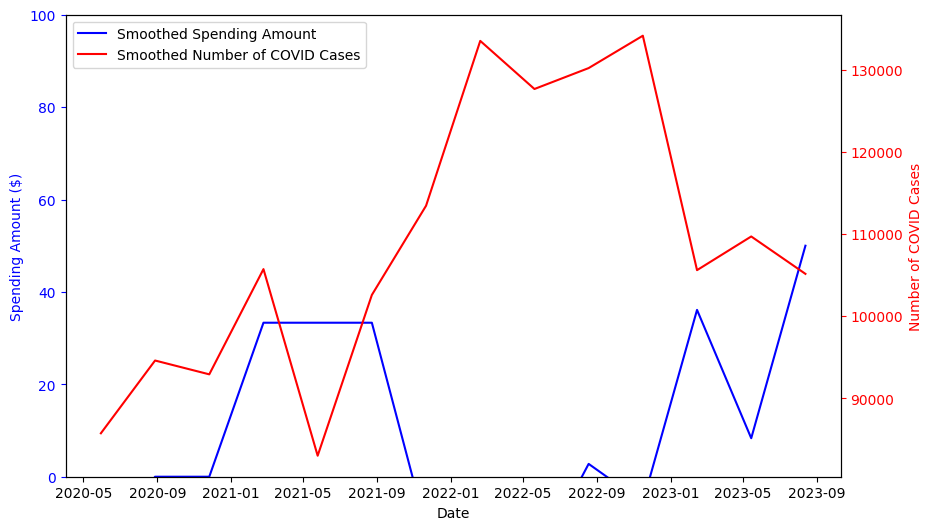

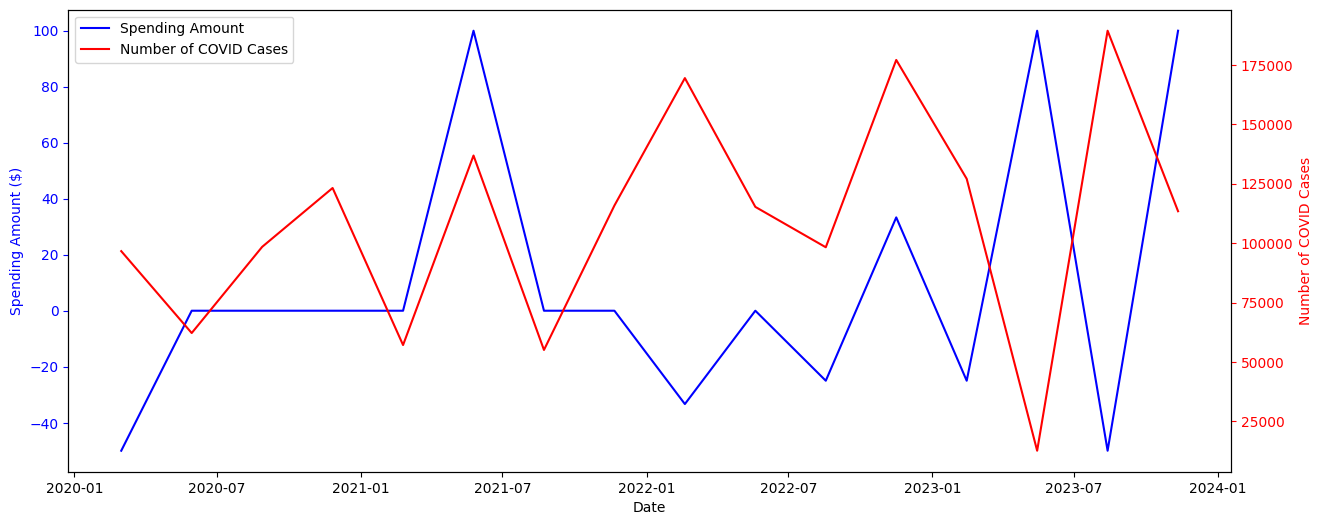

In [73]:
# Plot the spending history, number of COVID cases, and total savings
# Convert data to DataFrame
data = pd.DataFrame({
    'Date': dates,
    'Spending Amount': spending_percent_change_history,
    'COVID Cases': case_numbers
})
window_size = 3  # Adjust the window size as needed
data['Smooth Spending Amount'] = data['Spending Amount'].rolling(window_size, center=True).mean()
data['Smooth COVID Cases'] = data['COVID Cases'].rolling(window_size, center=True).mean()


# Plot the smoothed spending history and number of COVID cases
fig, ax1 = plt.subplots(figsize=(10, 6))

# Smoothed spending history plot
ax1.plot(data['Date'], data['Smooth Spending Amount'], color='b', label='Smoothed Spending Amount')
ax1.set_xlabel("Date")
ax1.set_ylabel("Spending Amount ($)", color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(0, 100)

# Smoothed number of COVID cases plot
ax2 = ax1.twinx()
ax2.plot(data['Date'], data['Smooth COVID Cases'], color='r', label='Smoothed Number of COVID Cases')
ax2.set_ylabel("Number of COVID Cases", color='r')
ax2.tick_params('y', colors='r')

# Set legend and rotate x-axis labels
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.xticks(rotation=45)

plt.show()

fig, ax1 = plt.subplots(figsize=(15, 6))

# Spending history plot
ax1.plot(dates, spending_percent_change_history, color='b', label='Spending Amount')
ax1.set_xlabel("Date")
ax1.set_ylabel("Spending Amount ($)", color='b')
ax1.tick_params('y', colors='b')

# Number of COVID cases plot
ax2 = ax1.twinx()
ax2.plot(dates, case_numbers, color='r', label='Number of COVID Cases')
ax2.set_ylabel("Number of COVID Cases", color='r')
ax2.tick_params('y', colors='r')


# Set legend and rotate x-axis labels
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2 , labels1 + labels2 , loc='upper left')
plt.xticks(rotation=45)

plt.show()

#### Langchain Hypothesis Testing

In [ ]:

# Set up OpenAI API key
llm = OpenAI(openai_api_key=OPENAI_API_KEY)

# Define a prompt template to get the spending probability from the language model
prompt_template = """
You are an individual living in New York City (NYC) during the COVID-19 pandemic. You have a monthly income of $5,000 and current savings of ${current_savings}. You need to decide how much to spend each month based on the current situation of the number of COVID cases in NYC and your remaining savings. Initially you were optimistic about the situation and were spending a larger portion of your income on non-essential expenses. However, as the number of COVID cases increased and your savings decreased, you became more cautious and started prioritizing essential expenses.

When the number of COVID cases is low and your savings are high, you feel more comfortable spending a larger portion of your income on non-essential expenses like dining out, entertainment, and travel. However, as the number of cases increases and your savings decrease, you become more cautious and prioritize essential expenses like rent, groceries, and utilities, reducing your spending on non-essential items.

To help you understand the context better:
- During a severe outbreak with a high number of COVID cases, people tend to stay at home more, avoid non-essential activities, and prioritize essential expenses like food and utilities. This reduces their overall spending, especially on non-essential items.
- When the number of cases is low, and people feel safer, they are more likely to resume normal activities like dining out, entertainment, and travel, leading to higher spending on non-essential items.
- Similarly, when individuals have higher savings, they feel more financially secure and are more willing to spend a larger portion of their income on non-essential expenses.
- As savings decrease, individuals become more cautious and try to preserve their savings by cutting back on non-essential spending and prioritizing essential expenses.

Given the current number of COVID cases in NYC and your remaining savings, provide a realistic probability between 0 and 1 representing the fraction of your monthly income you would want to spend this month. Your response should be in the following format:

Spending probability: X

Where X is a number between 0 and 1. Consider the following guidelines:

- If the number of cases is low, you feel relatively safe and would likely spend more percent of your income.
- If the number of cases is moderate, you become slightly more cautious and would likely start to reduce your spending and hence spend less percent of your income.
- If the number of cases is high, you become more concerned and would likely spend lower percentage of your income.
- If the number of cases is alarming, you become very cautious and would likely spend only small portion of your income and that on essential expenses.

Current number of COVID cases in NYC: {num_cases}
Current savings: ${current_savings}
"""
prompt = PromptTemplate(input_variables=["num_cases", "current_savings"], template=prompt_template)

# Define a function to simulate the spending behavior
def simulate_spending(start_date, end_date, initial_savings):
    savings = initial_savings
    earnings = 5000  # Assume a monthly income of $5,000
    spending_history = []
    dates = []
    case_numbers = []
    savings_history = [initial_savings]

    current_date = start_date
    while current_date <= end_date:
        # Simulate the number of COVID cases in NYC
        num_cases = random.randint(1000, 100000)
        case_numbers.append(num_cases)

        # Get the spending probability from the language model
        spending_prompt = prompt.format(num_cases=num_cases, current_savings=savings)
        spending_probability_str = llm(spending_prompt)

        # Extract the probability value from the output string
        spending_probability = float(spending_probability_str.split(": ")[1])

        # Calculate the spending amount based on the probability and earnings
        spending_amount = earnings * spending_probability

        # Update savings and record spending history
        savings+= earnings
        savings -= spending_amount
        spending_history.append(spending_amount)
        dates.append(current_date)
        savings_history.append(savings)

        # Move to the next month
        current_date += timedelta(days=30)

    return savings, spending_history, dates, case_numbers, savings_history

# Simulate the spending behavior from August 1, 2020, to July 31, 2021 (second wave of COVID-19)
start_date = datetime(2020, 3, 1)
end_date = datetime(2023, 12, 31)
initial_savings = 2000

final_savings, spending_history, dates, case_numbers, savings_history = simulate_spending(start_date, end_date, initial_savings)

print(f"Final savings after a year: ${final_savings:.2f}")
print("\nSpending history:")
for date, spending_amount, num_cases, savings in zip(dates, spending_history, case_numbers, savings_history):
    print(f"{date.strftime('%B %Y')}: COVID cases = {num_cases}, Spending = ${spending_amount:.2f}, Savings = ${savings:.2f}")

# Plot the spending history, number of COVID cases, and total savings
# Convert data to DataFrame
data = pd.DataFrame({
    'Date': dates,
    'Spending Amount': spending_history,
    'COVID Cases': case_numbers
})
window_size = 3  # Adjust the window size as needed
data['Smooth Spending Amount'] = data['Spending Amount'].rolling(window_size, center=True).mean()
data['Smooth COVID Cases'] = data['COVID Cases'].rolling(window_size, center=True).mean()


# Plot the smoothed spending history and number of COVID cases
fig, ax1 = plt.subplots(figsize=(10, 6))

# Smoothed spending history plot
ax1.plot(data['Date'], data['Smooth Spending Amount'], color='b', label='Smoothed Spending Amount')
ax1.set_xlabel("Date")
ax1.set_ylabel("Spending Amount ($)", color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(1000, 5000)

# Smoothed number of COVID cases plot
ax2 = ax1.twinx()
ax2.plot(data['Date'], data['Smooth COVID Cases'], color='r', label='Smoothed Number of COVID Cases')
ax2.set_ylabel("Number of COVID Cases", color='r')
ax2.tick_params('y', colors='r')

# Set legend and rotate x-axis labels
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.xticks(rotation=45)

plt.show()

fig, ax1 = plt.subplots(figsize=(15, 6))

# Spending history plot
ax1.plot(dates, spending_history, color='b', label='Spending Amount')
ax1.set_xlabel("Date")
ax1.set_ylabel("Spending Amount ($)", color='b')
ax1.tick_params('y', colors='b')

# Number of COVID cases plot
ax2 = ax1.twinx()
ax2.plot(dates, case_numbers, color='r', label='Number of COVID Cases')
ax2.set_ylabel("Number of COVID Cases", color='r')
ax2.tick_params('y', colors='r')


# Set legend and rotate x-axis labels
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2 , labels1 + labels2 , loc='upper left')
plt.xticks(rotation=45)

plt.show()

In [ ]:
from langchain import OpenAI, PromptTemplate
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt

# Set up OpenAI API key
llm = OpenAI(openai_api_key=OPENAI_API_KEY)

# Define a prompt template to get the spending probability from the language model
prompt_template = """
You are an individual living in New York City (NYC) during the COVID-19 pandemic. You have a monthly income of $5,000 and current savings of ${current_savings}. You need to decide how much to spend each month based on the current situation of the number of COVID cases in NYC and your remaining savings.

When the number of COVID cases is low and your savings are high, you feel more comfortable spending a larger portion of your income on non-essential expenses like dining out, entertainment, and travel. However, as the number of cases increases and your savings decrease, you become more cautious and prioritize essential expenses like rent, groceries, and utilities, reducing your spending on non-essential items.

To help you understand the context better:
- During a severe outbreak with a high number of COVID cases, people tend to stay at home more, avoid non-essential activities, and prioritize essential expenses like food and utilities. This reduces their overall spending, especially on non-essential items.
- When the number of cases is low, and people feel safer, they are more likely to resume normal activities like dining out, entertainment, and travel, leading to higher spending on non-essential items.
- Similarly, when individuals have higher savings, they feel more financially secure and are more willing to spend a larger portion of their income on non-essential expenses.
- As savings decrease, individuals become more cautious and try to preserve their savings by cutting back on non-essential spending and prioritizing essential expenses.

Given the current number of COVID cases in NYC and your remaining savings, provide a realistic probability between 0 and 1 representing the fraction of your monthly income you would want to spend this month, along with a brief explanation for your chosen spending probability. Your response should be in the following format:

Spending probability: X
Explanation: [Your explanation for the chosen spending probability]

Where X is a number between 0 and 1. Consider the following guidelines:

- If the number of cases is below 5,000 and your savings are above $50,000, you feel relatively safe and would likely spend around 80% of your income. The spending probability should be around 0.8.
- If the number of cases is between 5,000 and 20,000 or your savings are between $20,000 and $50,000, you become slightly more cautious and would likely spend around 60% of your income. The spending probability should be around 0.6.
- If the number of cases is between 20,000 and 50,000 or your savings are between $10,000 and $20,000, you become more concerned and would likely spend around 40% of your income. The spending probability should be around 0.4.
- If the number of cases is above 50,000 or your savings are below $10,000, you become very cautious and would likely spend only around 20% of your income on essential expenses. The spending probability should be around 0.2.

Current number of COVID cases in NYC: {num_cases}
Current savings: ${current_savings}
"""
prompt = PromptTemplate(input_variables=["num_cases", "current_savings"], template=prompt_template)

# Define a function to simulate the spending behavior
def simulate_spending(start_date, end_date, initial_savings):
    savings = initial_savings
    earnings = 5000  # Assume a monthly income of $5,000
    spending_history = []
    dates = [start_date]  # Append the initial date to the dates list
    case_numbers = []
    explanations = []

    current_date = start_date
    while current_date < end_date:
        # Simulate the number of COVID cases in NYC
        num_cases = random.randint(1000, 100000)
        case_numbers.append(num_cases)

        # Get the spending probability and explanation from the language model
        spending_prompt = prompt.format(num_cases=num_cases, current_savings=savings)
        spending_response = llm(spending_prompt)
        print(spending_response)
        spending_probability, explanation = spending_response.split("\n")
        spending_probability = float(spending_probability.split(": ")[1])
        explanation = explanation.split(": ")[1]

        # Calculate the spending amount based on the probability and earnings
        spending_amount = earnings * spending_probability

        # Update savings and record spending history
        savings -= spending_amount
        spending_history.append(spending_amount)
        dates.append(current_date)  # Append the current date to the dates list
        explanations.append(explanation)

        # Move to the next month
        current_date += timedelta(days=30)

    # Append the final date, spending amount, and explanation
    dates.append(end_date)
    spending_response = llm(prompt.format(num_cases=random.randint(1000, 100000), current_savings=savings))
    spending_probability, explanation = spending_response.split("\n")
    spending_history.append(earnings * float(spending_probability.split(": ")[1]))
    explanations.append(explanation.split(": ")[1])

    return savings, spending_history, dates, case_numbers, explanations

# Simulate the spending behavior from August 1, 2020, to July 31, 2021 (second wave of COVID-19)
start_date = datetime(2020, 8, 1)
end_date = datetime(2021, 7, 31)
initial_savings = 20000

final_savings, spending_history, dates, case_numbers, explanations = simulate_spending(start_date, end_date, initial_savings)

print(f"Final savings after a year: ${final_savings:.2f}")
print("\nSpending history:")
for date, spending_amount, num_cases, explanation in zip(dates, spending_history, case_numbers, explanations):
    print(f"{date.strftime('%B %Y')}: COVID cases = {num_cases}, Spending = ${spending_amount:.2f}")
    print(f"Explanation: {explanation}")
    print()

# Plot the spending history and number of COVID cases
fig, ax1 = plt.subplots(figsize=(10, 6))

# Spending history plot
ax1.plot(dates, spending_history, color='b', label='Spending Amount')
ax1.set_xlabel("Date")
ax1.set_ylabel("Spending Amount ($)", color='b')
ax1.tick_params('y', colors='b')

# Number of COVID cases plot
ax2 = ax1.twinx()
ax2.plot(dates, case_numbers, color='r', label='Number of COVID Cases')
ax2.set_ylabel("Number of COVID Cases", color='r')
ax2.tick_params('y', colors='r')

# Set legend and rotate x-axis labels
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.xticks(rotation=45)

plt.show()

In [ ]:
from langchain import OpenAI, PromptTemplate
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import pandas as pd

# Set up OpenAI API keys
api_key = OPENAI_API_KEY


# Create 20 LLM agents
llm_agents = [OpenAI(openai_api_key=api_key) for _ in range(20)]

# Define a prompt template to get the spending probability from the language model
prompt_template = """
You are an individual living in New York City (NYC) during the COVID-19 pandemic. You have a monthly income of $5,000 and current savings of ${current_savings}. You need to decide how much to spend each month based on the current situation of the number of COVID cases in NYC and your remaining savings.

When the number of COVID cases is low and your savings are high, you feel more comfortable spending a larger portion of your income on non-essential expenses like dining out, entertainment, and travel. However, as the number of cases increases and your savings decrease, you become more cautious and prioritize essential expenses like rent, groceries, and utilities, reducing your spending on non-essential items.

To help you understand the context better:
- During a severe outbreak with a high number of COVID cases, people tend to stay at home more, avoid non-essential activities, and prioritize essential expenses like food and utilities. This reduces their overall spending, especially on non-essential items.
- When the number of cases is low, and people feel safer, they are more likely to resume normal activities like dining out, entertainment, and travel, leading to higher spending on non-essential items.
- Similarly, when individuals have higher savings, they feel more financially secure and are more willing to spend a larger portion of their income on non-essential expenses.
- As savings decrease, individuals become more cautious and try to preserve their savings by cutting back on non-essential spending and prioritizing essential expenses.

Given the current number of COVID cases in NYC and your remaining savings, provide a realistic probability between 0 and 1 representing the fraction of your monthly income you would want to spend this month. Your response should be in the following format:

Spending probability: X

Where X is a number between 0 and 1. Consider the following guidelines:

- If the number of cases is low, you feel relatively safe and would likely spend more percent of your income.
- If the number of cases is moderate, you become slightly more cautious and would likely start to reduce your spending and hence spend less percent of your income.
- If the number of cases is high, you become more concerned and would likely spend lower percentage of your income.
- If the number of cases is alarming, you become very cautious and would likely spend only small portion of your income and that on essential expenses.

Current number of COVID cases in NYC: {num_cases}
Current savings: ${current_savings}
"""
prompt = PromptTemplate(input_variables=["num_cases", "current_savings"], template=prompt_template)

# Define a function to simulate the spending behavior
def simulate_spending(start_date, end_date, initial_savings, llm_agents):
    savings = initial_savings
    earnings = 5000  # Assume a monthly income of $5,000
    spending_history = []
    dates = []
    case_numbers = []
    savings_history = [initial_savings]

    current_date = start_date
    agent_index = 0
    while current_date <= end_date:
        # Simulate the number of COVID cases in NYC
        num_cases = random.randint(1000, 100000)
        case_numbers.append(num_cases)

        # Get the spending probability from the language model agent
        spending_prompt = prompt.format(num_cases=num_cases, current_savings=savings)
        spending_probability_str = llm_agents[agent_index](spending_prompt)

        # Extract the probability value from the output string
        spending_probability = float(spending_probability_str.split(": ")[1])

        # Calculate the spending amount based on the probability and earnings
        spending_amount = earnings * spending_probability

        # Update savings and record spending history
        savings += earnings
        savings -= spending_amount
        spending_history.append(spending_amount)
        dates.append(current_date)
        savings_history.append(savings)

        # Move to the next month and the next LLM agent
        current_date += timedelta(days=30)
        agent_index = (agent_index + 1) % len(llm_agents)

    return savings, spending_history, dates, case_numbers, savings_history

# Simulate the spending behavior from August 1, 2020, to July 31, 2021 (second wave of COVID-19)
start_date = datetime(2021, 3, 1)
end_date = datetime(2022, 12, 31)
initial_savings = 2000

final_savings, spending_history, dates, case_numbers, savings_history = simulate_spending(start_date, end_date, initial_savings, llm_agents)

# Aggregate the spending statistics across all LLM agents
total_spending = sum(spending_history)
average_spending = total_spending / len(spending_history)

print(f"Final savings after a year: ${final_savings:.2f}")
print(f"Total spending: ${total_spending:.2f}")
print(f"Average monthly spending: ${average_spending:.2f}")

# Plot the spending history and number of COVID cases
fig, ax1 = plt.subplots(figsize=(15, 6))

# Spending history plot
ax1.plot(dates, spending_history, color='b', label='Spending Amount')
ax1.set_xlabel("Date")
ax1.set_ylabel("Spending Amount ($)", color='b')
ax1.tick_params('y', colors='b')

# Number of COVID cases plot
ax2 = ax1.twinx()
ax2.plot(dates, case_numbers, color='r', label='Number of COVID Cases')
ax2.set_ylabel("Number of COVID Cases", color='r')
ax2.tick_params('y', colors='r')

# Set legend and rotate x-axis labels
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.xticks(rotation=45)

plt.show()